In [1]:
from rdflib.plugins.stores import sparqlstore
import rdflib
from rdflib import URIRef, Literal, Graph, Dataset

import serialization
import discourse

import html
import loader
import discourse
import pandas as pd
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from IPython.core.display import HTML

import uuid

from itertools import chain

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g


def nan2None(value):
    if pd.isnull(value) :
        return None
    else:
        return value


def get_data_rows(filename):
    data_rows_df = pd.read_csv(filename)
    data_rows=[]
    for i,r in data_rows_df.iterrows():
        r_d = {k:nan2None(v) for k,v in dict(r).items()}

        data_rows.append(r_d)
    del data_rows_df
    return data_rows


jena = sparqlstore.SPARQLUpdateStore("http://localhost:3030/modelg/query",context_aware=True)
jena.open(("http://localhost:3030/modelg/query", "http://localhost:3030/modelg/update"))
#jena.open(("http://localhost:3030/models/query", "http://localhost:3030/models/update"))

# Create a Dataset
ds = Dataset(store=jena, default_union=True, default_graph_base="http://base.raw")
#ds = Dataset(store=jena, default_union=True)
# Define a named graph within the dataset, this will contain all nodes contained within the graph referenced, or none if it doesn't exist yet.
sg = ds.graph(URIRef("http://config"))
sg = Graph()
master_g = ds.graph(URIRef("http://master"))
discourse_g = ds.graph(URIRef("http://discourse"))



* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MappingMetaTarget belongs to more than one entity types: [owl.AnnotationProperty, owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /usr/local/python/py36/lib/python3.6/site-packages/owlready2/hermit:/usr/local/python/py36/lib/python3.6/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/rd/q3bhk6_n56x75m05pp2sq7dr0000gn/T/tmpy3usk5gt


Serialization.Meta [Serialization.SerializationMetaData]
Serialization.Mapping [Serialization.SerializationSpecs]
Serialization.BatchDefinition [Serialization.SerializationSpecs]
Serialization.SerializationSpecs [Serialization.SerializationMetaData]
Serialization.BatchNode [Serialization.DataLoad]
Serialization.DataLoad [Serialization.SerializationMetaData]
Serialization.SerializationMetaData [owl.Thing]
Serialization.DataPropertyMapping [Serialization.Mapping]
Serialization.MetaDataProperty [Serialization.Meta]
Serialization.EntityMapping [Serialization.Mapping]
Serialization.MetaClass [Serialization.Meta]
Serialization.JobNode [Serialization.DataLoad]
Serialization.MetaProperty [Serialization.Meta]
Serialization.PropertyMapping [Serialization.Mapping]
Serialization.RowNode [Serialization.DataLoad]
Serialization.Serialization [Serialization.SerializationSpecs]


* Owlready2 * HermiT took 0.6767988204956055 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [2]:
def meta_data_package_template(field_d):
    dc_terms_base = "http://purl.org/dc/terms/"
    rdf_form = {}
    for k,v in field_d.items():
        rdf_form[URIRef(dc_terms_base + k)] = Literal(v)
    return rdf_form


def triples_to_quads(triples, graph="http://master"):
    for s,p,o, *_ in triples:
        yield (s,p,o,URIRef(graph))

In [3]:
if len(sg)==0:
    sg.parse("DMEAR_ser.rdf")
S = serialization.Serialization(sg, "EntityAttributeRecord")

In [4]:
file_dtypes = {'ModelDomain': str,
 'Model': str,
 'ModelType': str,
 'Class': str,
 'ClassDescription': str,
 'Attribute': str,
 'AttributeDescription': str,
 'DataType': str,
 'Context': str,
 'SubContext': str,
 'Nulls': str,
 'Is PK': str,
 'Relationship': str,
 'FromClass': str,
 'FromAttribute': str,
 'FromCardinality': str,
 'ToClass': str,
 'ToAttribute': str,
 'ToCardinality': str}

In [5]:
def get_field(v):
    if isinstance(v,str):
        return html.escape(str(v))
    elif isinstance(v,(int, float)):
        if pd.isnull(v):
            return None
        else:
            return v
    elif v is None or isinstance(v,pd.Null):
        return None

In [6]:
model_data = pd.read_csv(r"sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
d_p = meta_data_package_template( {"created" : "2023-04-10", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 1", 
                                   "title" : "inventory", 
                                   "modified" : "2023-04-10"})

rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

In [7]:
rows

[{'ModelDomain': 'Inventory',
  'Model': 'Simple ERD Model - Inventory',
  'ModelType': 'Physical',
  'Class': 'Product',
  'ClassDescription': 'Individual products and their descriptions',
  'Attribute': 'p_id',
  'AttributeDescription': 'Id field of the product by which it is coded',
  'DataType': 'integer',
  'Context': None,
  'SubContext': None,
  'Nulls': 'No',
  'Is PK': 'Yes',
  'Relationship': None,
  'FromClass': None,
  'FromAttribute': None,
  'FromCardinality': None,
  'ToClass': None,
  'ToAttribute': None,
  'ToCardinality': None},
 {'ModelDomain': 'Inventory',
  'Model': 'Simple ERD Model - Inventory',
  'ModelType': 'Physical',
  'Class': 'Product',
  'ClassDescription': 'Individual products and their descriptions',
  'Attribute': 'p_name',
  'AttributeDescription': 'Name of the product.',
  'DataType': 'string',
  'Context': None,
  'SubContext': None,
  'Nulls': 'No',
  'Is PK': 'No',
  'Relationship': None,
  'FromClass': None,
  'FromAttribute': None,
  'FromCardin

In [8]:
# Here master_g is a master graph sourced from Fuseki
mq,me_m = loader.get_triples(sg, "EntityAttributeRecord", rows, master_g, [])
p,de,di = loader.generate_discourse("Inventory ERD v1.0", mq, d_p)

ds.addN(triples_to_quads(mq, URIRef("http://master")))
ds.addN(triples_to_quads(p, URIRef("http://discourse")))
ds.addN(triples_to_quads(de, URIRef("http://discourse")))
ds.addN(triples_to_quads(di, URIRef("http://discourse")))


0:00:01.022517 for 9


In [9]:
model_data = pd.read_csv(r"sample/inventory_v2.csv", index_col="Sequence")
d_p = meta_data_package_template( {"created" : "2023-04-11", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 2", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-11"})

rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

# Here master_g is a master graph sourced from Fuseki
mq,me_m = loader.get_triples(sg, "EntityAttributeRecord", rows, master_g, [])
p,de,di = loader.generate_discourse("Inventory ERD v2.0", mq, d_p)

ds.addN(triples_to_quads(mq, URIRef("http://master")))
ds.addN(triples_to_quads(p, URIRef("http://discourse")))
ds.addN(triples_to_quads(de, URIRef("http://discourse")))
ds.addN(triples_to_quads(di, URIRef("http://discourse")))


0:00:00.043257 for 18


In [10]:
dict(model_data.dtypes)

{'ModelDomain': dtype('O'),
 'Model': dtype('O'),
 'ModelType': dtype('O'),
 'Class': dtype('O'),
 'ClassDescription': dtype('O'),
 'Attribute': dtype('O'),
 'AttributeDescription': dtype('O'),
 'DataType': dtype('O'),
 'Context': dtype('float64'),
 'SubContext': dtype('float64'),
 'Nulls': dtype('O'),
 'Is PK': dtype('O'),
 'Relationship': dtype('O'),
 'FromClass': dtype('O'),
 'FromAttribute': dtype('O'),
 'FromCardinality': dtype('O'),
 'ToClass': dtype('O'),
 'ToAttribute': dtype('O'),
 'ToCardinality': dtype('O')}

In [11]:
model_data = pd.read_csv(r"sample/inventory_v3.csv", index_col="Sequence")
d_p = meta_data_package_template( {"created" : "2023-04-14", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 3", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-14"})

rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

# Here master_g is a master graph sourced from Fuseki
mq,me_m = loader.get_triples(sg, "EntityAttributeRecord", rows, master_g, [])
p,de,di = loader.generate_discourse("Inventory ERD v3.0", mq, d_p)

ds.addN(triples_to_quads(mq, URIRef("http://master")))
ds.addN(triples_to_quads(p, URIRef("http://discourse")))
ds.addN(triples_to_quads(de, URIRef("http://discourse")))
ds.addN(triples_to_quads(di, URIRef("http://discourse")))


0:00:00.090111 for 44


In [12]:
# Step 1 - Tell me what discourses are available in the system

In [13]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created 
"""

qr = ds.query(discourse_details_sparql)

In [14]:
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df

,g,discourse,name,title,description,created,declarations,entities
1,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v1.0,inventory,Sample ERD model version 1,2023-04-10,75,14
5,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v1.0,inventory,Sample ERD model version 1,2023-04-10,75,14
0,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v2.0,inventory ERD,Sample ERD model version 2,2023-04-11,143,27
2,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v2.0,inventory ERD,Sample ERD model version 2,2023-04-11,143,27
3,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v3.0,inventory ERD,Sample ERD model version 3,2023-04-14,309,59
4,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v3.0,inventory ERD,Sample ERD model version 3,2023-04-14,309,59


https://docs.data.world/tutorials/sparql/list-of-sparql-filter-functions.html

In [15]:
discourses = list(discourse_df['discourse'])
discourses

[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/533952b2474a45e78af9bc3ff8ca6466'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/e6096146459845029b43e9b5506c75e0'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/05edfec9da5c4ba9bd981bc33f5c99aa'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/44f5d6546c4541e58933aae0af5b2cad'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/42232afd7ab14570bb412c1d137b8524'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/8c0568d66e024ffaa4f323f5a6ad4224')]

In [16]:
discourses[0].n3()

'<http://www.semanticweb.org/tomk/ontologies/2022/11/533952b2474a45e78af9bc3ff8ca6466>'

In [34]:
# Given two discourse urls, d1, d2, pull all the discourse-data associated 
# - including the reified triples they reference


get_posits_by_discourse_sparql = """

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?assertion ?refutation ?posit ?s ?p ?o
WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?assertion. 
                   ?assertion disco:Subject ?s.
                   ?assertion disco:Predicate ?p.
                   ?assertion disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Refutes ?refutation. 
                   ?refutation disco:Subject ?s.
                   ?refutation disco:Predicate ?p.
                   ?refutation disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Posits ?posit. 
                   ?posit disco:Subject ?s.
                   ?posit disco:Predicate ?p.
                   ?posit disco:Object ?o.
        }
      FILTER (?discourse IN ( %%d1%%, %%d2%% )) .
      
  }
}

""".replace("%%d1%%",discourses[0].n3()).replace("%%d2%%", discourses[2].n3())

qr = ds.query(get_posits_by_discourse_sparql)

In [35]:
discourse_contents = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="discourse")

In [60]:
discourse_contents['triple'] = discourse_contents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)

In [61]:
d_set_d = discourse_contents.groupby(['discourse'])['triple'].agg(set).to_dict()


#d_set_d = discourse_contents.groupby(['discourse']).agg(set).to_dict()


In [63]:
d_set_d

{rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/05edfec9da5c4ba9bd981bc33f5c99aa'): {(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/072cb60831bc46449c4ed8e3f214964f'),
   rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'),
   rdflib.term.Literal('Inventory.Simple ERD Model - Inventory.Product.description')),
  (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/072cb60831bc46449c4ed8e3f214964f'),
   rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#DataType'),
   rdflib.term.Literal('string')),
  (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/072cb60831bc46449c4ed8e3f214964f'),
   rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
   rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')),
  (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2

In [64]:
key_l = list(d_set_d.keys())

In [65]:
def diffset(S1, S2):
    # Given two input sets, s1 and s2, return the Left difference, Intersection and Right difference between them
    L = S1.difference(S2)
    I = S1.intersection(S2)
    R = S2.difference(S1)
    return L,I,R

In [67]:
print("(intersection, left_diff, right_diff)")
len(d_set_d[key_l[0]].intersection(d_set_d[key_l[1]])), len(d_set_d[key_l[0]].difference(d_set_d[key_l[1]])), len(d_set_d[key_l[1]].difference(d_set_d[key_l[0]]))
s1,s2 = d_set_d[key_l[0]], d_set_d[key_l[1]]
ds = diffset(s1,s2)
[len(d) for d in ds], len(s1), len(s2)


(intersection, left_diff, right_diff)


([68, 75, 0], 143, 75)

In [85]:
# Feed diffset split sets of SPO triples
def visualise_ERD_diffset(L, I, R):
    l_graph = Graph()
    l_graph.addN(triples_to_quads(L, URIRef("http://temp")))
    i_graph = Graph()
    i_graph.addN(triples_to_quads(I, URIRef("http://temp")))
    r_graph = Graph()
    r_graph.addN(triples_to_quads(R, URIRef("http://temp")))
    
    
    

In [86]:

l_graph=visualise_ERD_diffset(*diffset(s1, s2))
l_graph

<Graph identifier=Na630ae829a7549bfa6bd8c5866015baa (<class 'rdflib.graph.Graph'>)>

In [81]:
discourse_contents

,g,discourse,assertion,refutation,posit,s,p,o,triple
108,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,Inventory,(http://www.semanticweb.org/tomk/ontologies/20...
138,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/2000/01/rdf-schema#label,loc_name,(http://www.semanticweb.org/tomk/ontologies/20...
139,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,Inventory.Simple ERD Model - Inventory.Staff.s...,(http://www.semanticweb.org/tomk/ontologies/20...
140,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.semanticweb.org/tomk/ontologies/202...,(http://www.semanticweb.org/tomk/ontologies/20...
141,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,(http://www.semanticweb.org/tomk/ontologies/20...
...,...,...,...,...,...,...,...,...,...
52,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,(http://www.semanticweb.org/tomk/ontologies/20...
54,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/2000/01/rdf-schema#label,Simple ERD Model - Inventory,(http://www.semanticweb.org/tomk/ontologies/20...
55,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.semanticweb.org/tomk/ontologies/202...,(http://www.semanticweb.org/tomk/ontologies/20...
47,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,(http://www.semanticweb.org/tomk/ontologies/20...


In [26]:
discourses

[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/533952b2474a45e78af9bc3ff8ca6466'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/e6096146459845029b43e9b5506c75e0'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/05edfec9da5c4ba9bd981bc33f5c99aa'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/44f5d6546c4541e58933aae0af5b2cad'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/42232afd7ab14570bb412c1d137b8524'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/8c0568d66e024ffaa4f323f5a6ad4224')]

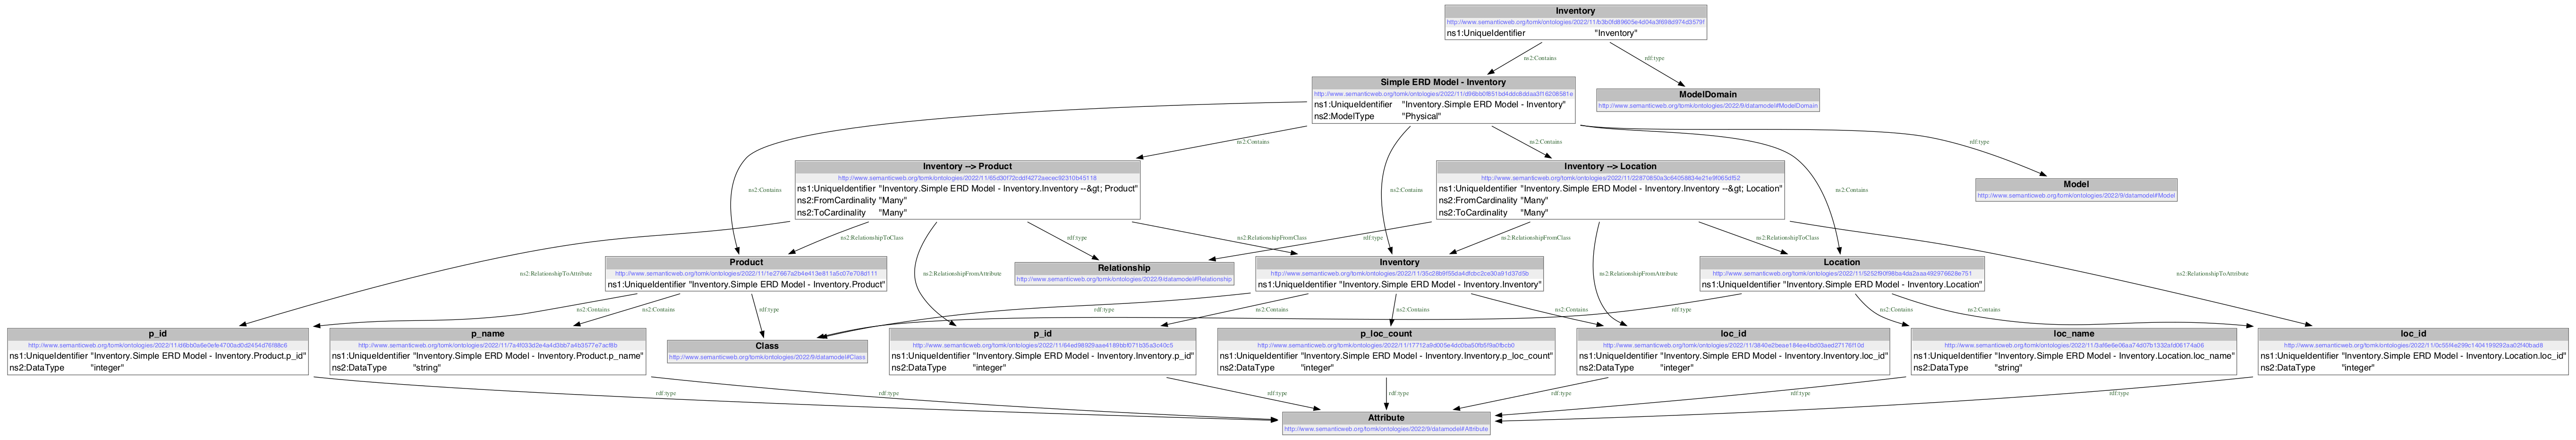

In [25]:
visualize(t2rdflibg( discourse_contents[discourse_contents['discourse']==discourses[1]][['s','p','o']].values))